In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, train_test_split
from scipy.stats import randint as sp_randint
from time import time
from sklearn.metrics import roc_curve, auc
from scipy import interp
from pylab import rcParams
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score

In [2]:
rcParams['figure.figsize'] = 12, 8

In [3]:
df = pd.read_csv('/home/alexshein/processed_pals/S10-20_L0-8_M5/AluL1LastVSRandom.csv', sep=';')
df = df[[i for i in list(df.columns) if i not in ('Unnamed: 0')]]
df = df.fillna(value=0.0)

In [4]:
df.describe()

,AA,AAA,AAC,AAG,AAT,AC,ACA,ACC,ACG,ACT,...,TGA,TGC,TGG,TGT,TT,TTA,TTC,TTG,TTT,is_target
count,38529.000000,38529.000000,38529.000000,38529.000000,38529.000000,38529.000000,38529.000000,38529.000000,38529.000000,38529.000000,...,38529.000000,38529.000000,38529.000000,38529.000000,38529.000000,38529.000000,38529.000000,38529.00000,38529.000000,38529.000000
mean,0.573698,0.110826,0.093228,0.063355,0.086195,0.549794,0.135430,0.088401,0.026292,0.102598,...,0.054375,0.119910,0.043396,0.131719,0.660178,0.073840,0.202679,0.06621,0.097329,0.480910
std,0.751987,0.333951,0.297114,0.249082,0.299013,0.753121,0.354482,0.285885,0.161136,0.308106,...,0.233080,0.372222,0.208035,0.349066,0.728543,0.279273,0.405216,0.25443,0.315908,0.499642
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,1.000000
max,5.000000,3.000000,2.000000,2.000000,3.000000,4.000000,2.000000,2.000000,2.000000,3.000000,...,3.000000,3.000000,2.000000,3.000000,5.000000,3.000000,2.000000,2.00000,3.000000,1.000000


In [5]:
df[df['is_target']==1]['GC precentage'].describe()

count    18529.000000
mean        37.739768
std         11.186869
min          0.000000
25%         28.571429
50%         37.500000
75%         50.000000
max         68.000000
Name: GC precentage, dtype: float64

In [6]:
df[df['is_target']==0]['GC precentage'].describe()

count    20000.000000
mean        23.868346
std         13.523089
min          0.000000
25%         13.636364
50%         22.727273
75%         32.000000
max         77.272727
Name: GC precentage, dtype: float64

In [7]:
dfX = df[[i for i in list(df.columns) if i not in ('is_target')]]
dfY = df['is_target']

In [8]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=300, max_depth=5)

In [9]:
def draw_roc_auc(dfX, dfY, rf):
    folded_data = model_selection.KFold(n_splits=5)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    i = 0

    for k, (train, test) in enumerate(folded_data.split(dfX, dfY)):
        probas_ = rf.fit(dfX.iloc[train], dfY.iloc[train]).predict_proba(dfX.iloc[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(dfY.iloc[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(
            fpr,
            tpr,
            lw=1,
            alpha=0.3,
            label='ROC fold %d (AUC = %0.2f)' % (k, roc_auc)
        )

    plt.plot(
        [0, 1],
        [0, 1],
        linestyle='--',
        lw=2,
        color='r',
        label='Luck',
        alpha=.8
    )
    fpr, tpr, thresholds = roc_curve(dfY.iloc[test], probas_[:, 1])

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color='grey',
        alpha=.2,
        label=r'$\pm$ 1 std. dev.'
    )

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for transposon recognition')
    plt.legend(loc="lower right")
    plt.show()
    list(sorted(zip(dfX.columns, rf.feature_importances_), key=lambda x:x[1], reverse=True))[:20]

In [10]:
def draw_precision_recall(dfX, dfY, rf):
    folded_data = model_selection.KFold(n_splits=5)
    precisions = []
    for k, (train, test) in enumerate(folded_data.split(dfX, dfY)):
        probas_ = rf.fit(dfX.iloc[train], dfY.iloc[train]).predict_proba(dfX.iloc[test])
        precision, recall, _ = precision_recall_curve(dfY.iloc[test], probas_[:, 1])
        precisions.append(average_precision_score(dfY.iloc[test], probas_[:, 1]))
        plt.step(
            recall,
            precision,
            alpha=0.5,
            where='post',
            label='Precision-recall fold {}'.format(k)
        )
    average_precision = sum(precisions)/len(precisions)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision))
    plt.legend(loc="lower right")
    plt.show()

In [11]:
# Results WITH Di-Trinucleotides count features

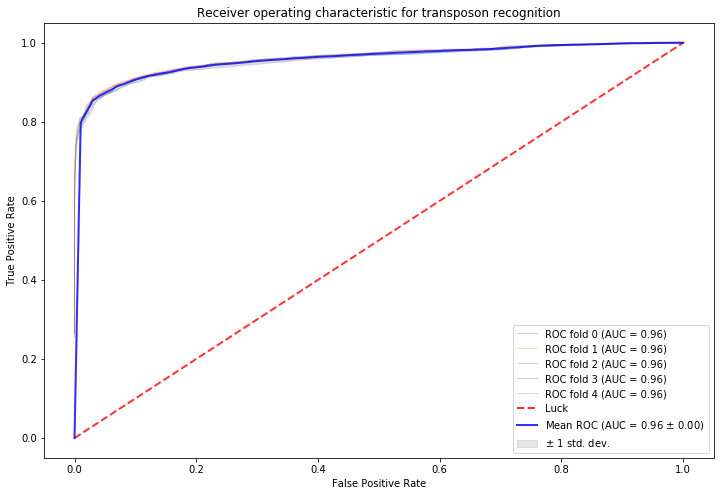

[('GC precentage', 0.04827429927825283),
 ('CTC', 0.0393960726313823),
 ('GAG', 0.03922876261814001),
 ('AG', 0.03833643137775923),
 ('RS3Shift (RNA)', 0.03600867340144725),
 ('RS0Hydrophilicity (RNA)', 0.03184844818014531),
 ('LS0Hydrophilicity (RNA)', 0.029697334275793987),
 ('RS6Hydrophilicity (RNA)', 0.024417552012271485),
 ('RS0Free energy (RNA)', 0.024115573542679347),
 ('TC', 0.02386891661823658),
 ('LS0Twist (RNA)', 0.022912285192267085),
 ('CT', 0.02070232282365295),
 ('RS7Tilt (RNA)', 0.019649389409283284),
 ('AC', 0.01817507956499086),
 ('RS3Free energy (RNA)', 0.016594712674364385),
 ('RS0Rise (RNA)', 0.015431702470683394),
 ('TGC', 0.014763807989303454),
 ('RS7Shift (RNA)', 0.013203860968447872),
 ('RS0Tilt (RNA)', 0.013180021679358191),
 ('LS6Rise (RNA)', 0.01295629213161789)]

In [12]:
draw_roc_auc(dfX, dfY, rf)
list(sorted(zip(dfX.columns, rf.feature_importances_), key=lambda x:x[1], reverse=True))[:20]

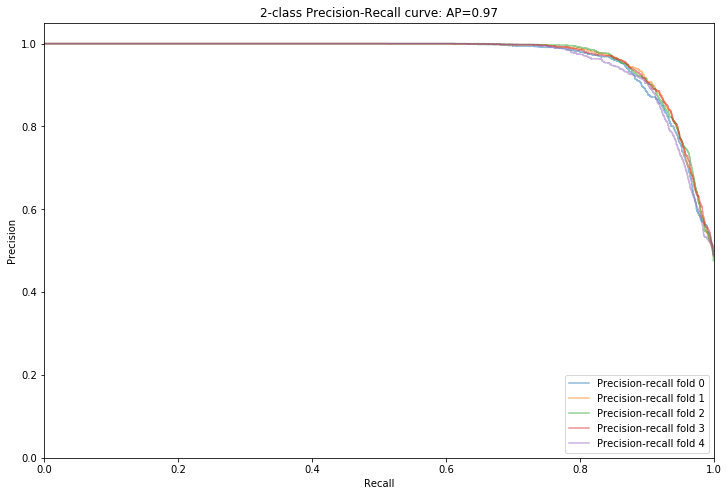

In [13]:
draw_precision_recall(dfX, dfY, rf)

In [14]:
df2 = df[
    [col for col in list(df.columns) if col.startswith('LP') or
     col.startswith('LB') or
     col.startswith('RB') or
     col.startswith('LS') or
     col.startswith('RS') or
     col.startswith('GC p') or
     col == 'is_target'
    ]
]

In [15]:
df2.head()

,GC precentage,LB0A,LB0C,LB0G,LB0T,LB1A,LB1C,LB1G,LB1T,LB2A,...,RS8Entropy (RNA),RS8Free energy (RNA),RS8Hydrophilicity (RNA),RS8Rise (RNA),RS8Roll (RNA),RS8Shift (RNA),RS8Slide (RNA),RS8Tilt (RNA),RS8Twist (RNA),is_target
0,28.000000,0,1,0,0,0,0,0,1,0,...,-27.8875,-2.134375,0.265,3.2525,8.5,0.053125,-1.523125,0.4375,31.4375,0
1,33.333333,1,0,0,0,0,0,1,0,1,...,-27.8875,-2.134375,0.265,3.2525,8.5,0.053125,-1.523125,0.4375,31.4375,1
2,52.173913,0,1,0,0,0,0,0,1,0,...,-27.8875,-2.134375,0.265,3.2525,8.5,0.053125,-1.523125,0.4375,31.4375,0
3,18.181818,0,0,0,1,0,1,0,0,1,...,-27.8875,-2.134375,0.265,3.2525,8.5,0.053125,-1.523125,0.4375,31.4375,0
4,31.818182,0,1,0,0,1,0,0,0,0,...,-32.5000,-2.350000,0.480,3.3800,9.4,0.070000,-1.700000,1.3000,32.0000,0


In [16]:
df2X = df2[[i for i in list(df2.columns) if i not in ('is_target')]]
df2Y = df2['is_target']

In [17]:
rf2 = RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=5)


In [18]:
# Results WITHOUT Di-Trinucleotides count features

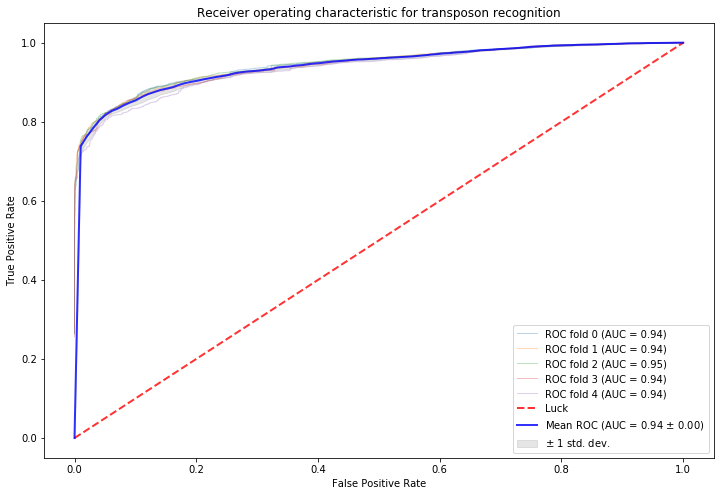

[('GC precentage', 0.08710604876399357),
 ('RS0Hydrophilicity (RNA)', 0.049786040823731746),
 ('LS0Hydrophilicity (RNA)', 0.04971426815381671),
 ('RS0Rise (RNA)', 0.04626046336687198),
 ('RS0Tilt (RNA)', 0.04446359233218897),
 ('RS3Shift (RNA)', 0.041708937640096345),
 ('RS3Free energy (RNA)', 0.03808186991029288),
 ('RS7Tilt (RNA)', 0.024510104470224815),
 ('LS0Twist (RNA)', 0.02082906831422336),
 ('RS7Rise (RNA)', 0.01872398406435728),
 ('RS6Hydrophilicity (RNA)', 0.018579176625802038),
 ('LS7Twist (RNA)', 0.0181219832320916),
 ('LS6Hydrophilicity (RNA)', 0.014903186576771725),
 ('LP0C', 0.01479684745921044),
 ('RS4Shift (RNA)', 0.014427692637091953),
 ('RS7Shift (RNA)', 0.013912294083584173),
 ('RS3Roll (RNA)', 0.01202449974988184),
 ('RS6Twist (RNA)', 0.011828283765740032),
 ('RS3Enthalpy (RNA)', 0.011335826155795843),
 ('LS7Hydrophilicity (RNA)', 0.011084985043909305)]

In [19]:
draw_roc_auc(df2X, df2Y, rf2)

list(sorted(zip(df2X.columns, rf2.feature_importances_), key=lambda x:x[1], reverse=True))[:20]
# top_features = list(sorted(zip(df2X.columns, rf2.feature_importances_), key=lambda x: x[1], reverse=True))
# top_features

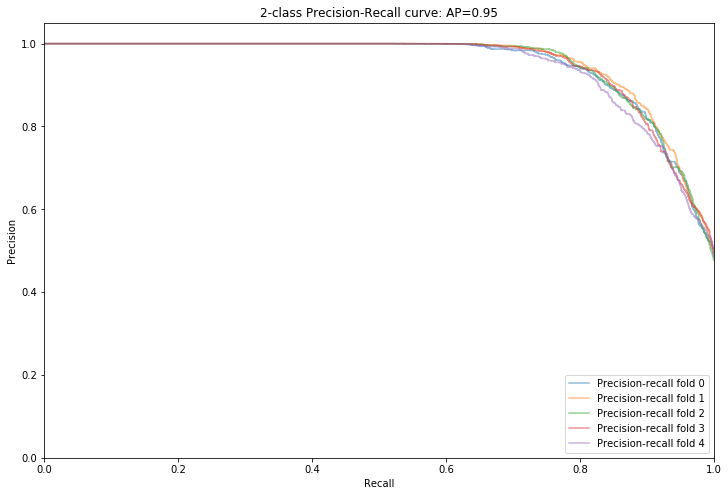

In [20]:
draw_precision_recall(df2X, df2Y, rf2)

In [21]:
top_features = list(sorted(zip(df2X.columns, rf2.feature_importances_), key=lambda x:x[1], reverse=True))[:20]
pd.DataFrame(
    columns=df2X.columns, data=[
        df2X[df2Y==1].mean(),
        df2X[df2Y==0].mean(),
        df2X[df2Y==1].std(),
        df2X[df2Y==0].std()
    ],
    index=['Mean t', 'Mean f', 'Std t', 'Std f']
).round(2)[list(filter(bool, map(lambda x: x[0], top_features)))[:20]]

,GC precentage,RS3Shift (RNA),LS0Hydrophilicity (RNA),LS0Twist (RNA),RS0Tilt (RNA),RS3Free energy (RNA),RS0Hydrophilicity (RNA),RS6Hydrophilicity (RNA),RS7Tilt (RNA),RS7Rise (RNA),RS0Rise (RNA),LS6Rise (RNA),LS3Shift (RNA),LS3Rise (RNA),RS0Shift (RNA),LP0C,LS1Hydrophilicity (RNA),RS0Slide (RNA),RS7Hydrophilicity (RNA),RS6Twist (RNA)
Mean t,37.74,0.15,0.16,30.79,0.76,-2.21,0.38,0.37,0.84,3.29,3.30,3.30,0.07,3.23,0.06,0.62,0.23,-1.57,0.34,30.89
Mean f,23.87,0.04,0.26,31.44,0.40,-2.06,0.26,0.26,0.41,3.25,3.24,3.25,0.05,3.25,0.04,0.21,0.26,-1.50,0.26,31.46
Std t,11.19,0.12,0.10,0.86,0.59,0.22,0.11,0.13,0.41,0.08,0.08,0.07,0.05,0.06,0.06,0.49,0.07,0.13,0.12,0.77
Std f,13.52,0.05,0.10,0.68,0.46,0.41,0.10,0.08,0.40,0.05,0.05,0.04,0.06,0.04,0.06,0.41,0.07,0.10,0.08,0.59
